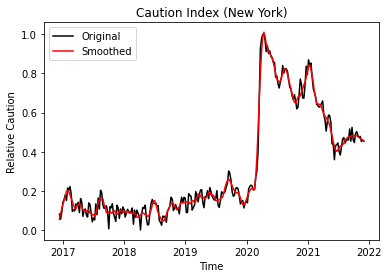

In [456]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
#from matplotlib.dates import DateFormatter
#import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#import datetime
from scipy import stats
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.var_model import VAR
#from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank

%matplotlib inline

def mape(actual, fc): 
    actual, fc = np.array(actual), np.array(fc)
    return np.mean(np.abs((actual - fc) / actual)) * 100

def func_exp(t, tau):
    return np.exp(-t / tau)

df1 = pd.read_csv("C:\\Users\\Ping\\Desktop\\Project\\COVID_prediction\\data\\gtrend_caution.csv") 
df1.head()
df1['date'] = pd.to_datetime(df1.date)
df1.set_index("date", inplace = True)

fig, ax = plt.subplots()
ax.plot(df1.caution,'k-')
ax.set_xlabel("Time")
ax.set_ylabel("Relative Caution")
ax.set_title("Caution Index (New York)")

# Baseline period 2017-2019 should be flat
df1['caution_sm'] = savgol_filter(df1.caution, window_length = 11, polyorder = 2)
ax.plot(df1.caution_sm,'r-')
ax.legend(['Original','Smoothed'])
plt.show()

df1['caution'] = df1['caution_sm']

(array([18262., 18353., 18444., 18536., 18628., 18718., 18809., 18901.,
        18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

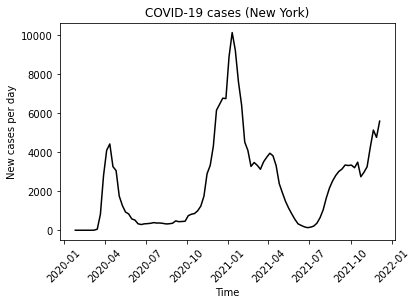

In [457]:
#Read in COVID case numbers, diff, plot, plot autoregression 

df2 = pd.read_csv('C:\\Users\\Ping\\Desktop\\Project\\COVID_prediction\\data\\United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv') 
df2['submission_date']=pd.to_datetime(df2.submission_date)
df2.set_index('submission_date', inplace = True)
df2 = df2[df2.state=="NY"]
#df2 = df2[df2.state=="CA"]
df2.head()

# Remove commas and make data type int
#df2.new_case = df2.new_case.str.replace(',','').astype('int64', errors = 'raise')

# Aggregate to weekly
new_cases = df2.new_case.resample('W').mean()

plt.plot(new_cases,'k-')
plt.xlabel('Time')
plt.ylabel('New cases per day')
plt.title('COVID-19 cases (New York)')
plt.xticks(rotation=45)


C:\Users\Ping\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:741: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(


,temp_C
month_date,
2019-01-20,2.000000
2019-01-27,1.639374
2019-02-03,1.431490
2019-02-10,1.450395
2019-02-17,2.000000
...,...
2022-11-20,9.000000
2022-11-27,9.317951
2022-12-04,8.822310


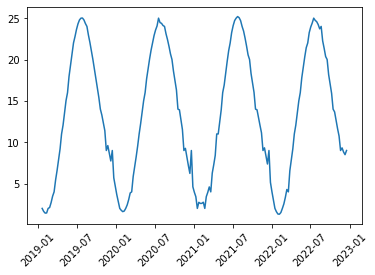

In [458]:
df3 = pd.read_csv('C:\\Users\\Ping\\Desktop\\Project\\COVID_prediction\\data\\ny_weather.csv') 
df3['month_date']=pd.to_datetime(df3.month_date)
df3.set_index('month_date', inplace = True)

# Other way
#df3['yyyy'] = pd.to_datetime(df3['month_date']).dt.year
#df3['mm'] = pd.to_datetime(df3['month_date']).dt.month
#df3['dd'] = pd.to_datetime(df3['month_date']).dt.day

#duplicate to multiyear
#df3_copy1 = df3.copy()
#df3_copy1['yyyy'] = df3_copy1['yyyy']-1
#df3_copy1['month_date'] = df3['mm'].astype(str) +'/'+ df3['dd'].astype(str) + '/'+ df3_copy1['yyyy'].astype(str)

#df3_copy2 = df3.copy()
#df3_copy2['yyyy'] = df3_copy2['yyyy']+1
#df3_copy2['month_date'] = df3['mm'].astype(str) +'/'+ df3['dd'].astype(str) + '/'+ df3_copy2['yyyy'].astype(str)

#df3_copy3 = df3.copy()
#df3_copy3['yyyy'] = df3_copy3['yyyy']+2
#df3_copy3['month_date'] = df3['mm'].astype(str) +'/'+ df3['dd'].astype(str) + '/'+ df3_copy3['yyyy'].astype(str)

df3_copy1 = df3.copy()
df3_copy1.index = df3_copy1.index + pd.DateOffset(year=2019)
df3_copy2 = df3.copy()
df3_copy2.index = df3_copy2.index + pd.DateOffset(year=2021)
df3_copy3 = df3.copy()
df3_copy3.index = df3_copy3.index + pd.DateOffset(year=2022)

df3_long = pd.concat([df3_copy1,df3,df3_copy2,df3_copy3],axis=0)
#df3_long['month_date']=pd.to_datetime(df3_long.month_date)
#df3_long.set_index('month_date', inplace = True)

df3_long = df3_long.resample('W').mean().interpolate(method='spline',order=3)

plt.plot(df3_long)
plt.xticks(rotation=45)

df3_long

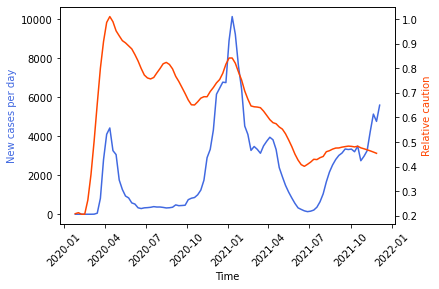

,caution,caution_sm,new_case,temp_C


In [459]:
# Merge the full date range into previous
df_merged = pd.merge(df1,new_cases, how='inner',left_index=True,right_index=True)
df_merged = pd.merge(df_merged,df3_long, how='inner',left_index=True,right_index=True)

# Coplot full range
fig,ax = plt.subplots()
ax.plot(new_cases,color='royalblue')
ax.set_ylabel('New cases per day',color='royalblue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax2 = ax.twinx()
ax2.plot(df_merged.caution,color='orangered')
ax2.set_ylabel('Relative caution',color='orangered')

plt.show()

fig.savefig('Caution_and_new_cases.png',
            format='png',
            dpi=100,
            bbox_inches='tight')

# Skip initial period of pandemic
df_during = df_merged['2020-04-10':]
# Check for any embedded NaN's that need to be filled
df_during[df_during.caution.isna()==True]

C:\Users\Ping\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


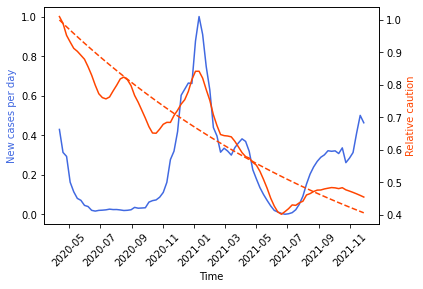

In [471]:
# Coplot 
fig,ax = plt.subplots()
ax.plot(df_during.new_case,color='royalblue')
ax.set_ylabel('New cases per day',color='royalblue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax2 = ax.twinx()
ax2.plot(df_during.caution,color='orangered')
ax2.set_ylabel('Relative caution',color='orangered')

np.random.seed(0)
t = np.arange(0,len(df_during.caution))
params, cov = curve_fit(func_exp, t, df_during.caution.values)
tau = params
y_fit = func_exp(t, tau)
# Doing a fit with amplitude and offset produces very large coefficients that doesn't reflect asymptoting,
# here we are forcing asymptoting

df_during.loc[:,'caution2'] = df_during.caution-y_fit

ax2.plot(df_during.index, y_fit, color='orangered',linestyle = '--')

plt.show()

#fig.savefig('Caution_and_new_cases.png',
#            format='png',
#            dpi=100,
#            bbox_inches='tight')

C:\Users\Ping\AppData\Local\Temp/ipykernel_1420/3332752693.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['caution2']= (df_during.caution2-min_cau)/(range_cau)
C:\Users\Ping\AppData\Local\Temp/ipykernel_1420/3332752693.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['new_case']= (df_during.new_case-df_during.new_case.min())/(df_during.new_case.max()-df_during.new_case.min())


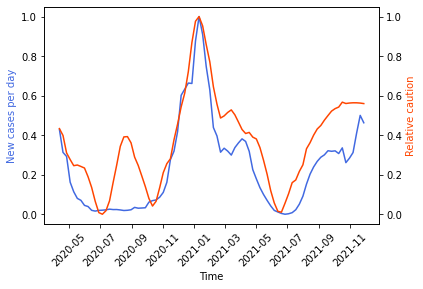

C:\Users\Ping\AppData\Local\Temp/ipykernel_1420/3332752693.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['log_caution'] = np.log(df_during['caution2']+epsilon)
C:\Users\Ping\AppData\Local\Temp/ipykernel_1420/3332752693.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['log_new_case'] = np.log(df_during['new_case']+epsilon)


array([[1.        , 0.78504364],
       [0.78504364, 1.        ]])

In [474]:
# Max-min normalize
min_cau = np.min(df_during.caution2)
range_cau = np.max(df_during.caution2)-np.min(df_during.caution2)
df_during['caution2']= (df_during.caution2-min_cau)/(range_cau)
df_during['new_case']= (df_during.new_case-df_during.new_case.min())/(df_during.new_case.max()-df_during.new_case.min())

fig,ax = plt.subplots()
ax.plot(df_during.new_case,color='royalblue')
ax.set_ylabel('New cases per day',color='royalblue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)
#ax.plot(df_during.new_case.diff(),color='black')

ax2 = ax.twinx()
ax2.plot(df_during.caution2,color='orangered')
ax2.set_ylabel('Relative caution',color='orangered')

plt.show()

epsilon = 0.01  # Prevent -inf
df_during['log_caution'] = np.log(df_during['caution2']+epsilon)
df_during['log_new_case'] = np.log(df_during['new_case']+epsilon)

np.corrcoef(df_during.log_caution, df_during.log_new_case)

In [436]:
print(sm.tsa.stattools.adfuller(df_during.caution2))
print(sm.tsa.stattools.adfuller(df_during.new_case))

# One round of differencing makes stationary
print(sm.tsa.stattools.adfuller(df_during.caution.diff().dropna()))
print(sm.tsa.stattools.adfuller(df_during.new_case.diff().dropna()))

# Log transform also works
print(sm.tsa.stattools.adfuller(df_during.log_caution))
print(sm.tsa.stattools.adfuller(df_during.log_new_case))


(-2.1427634996340927, 0.2276703026258486, 9, 76, {'1%': -3.5194805351545413, '5%': -2.9003945086747343, '10%': -2.5874984279778395}, -325.44462790528814)
(-2.1408716722765755, 0.22840050660386335, 1, 84, {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152}, -224.2073270915622)
(-3.436870064817822, 0.009764378072376909, 8, 76, {'1%': -3.5194805351545413, '5%': -2.9003945086747343, '10%': -2.5874984279778395}, -490.224357772649)
(-5.12617783308809, 1.2415723706919786e-05, 0, 84, {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152}, -217.29635760126746)
(-2.882452272989269, 0.04742694267164199, 3, 82, {'1%': -3.512738056978279, '5%': -2.8974898650628984, '10%': -2.585948732897085}, -3.8161388827763005)
(-3.076627327456718, 0.028331922005594215, 2, 83, {'1%': -3.5117123057187376, '5%': -2.8970475206326833, '10%': -2.5857126912469153}, -52.39264297525543)


In [437]:
grangercausalitytests(df_during[['log_caution','log_new_case']],maxlag=4)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5432  , p=0.1146  , df_denom=82, df_num=1
ssr based chi2 test:   chi2=2.6363  , p=0.1044  , df=1
likelihood ratio test: chi2=2.5962  , p=0.1071  , df=1
parameter F test:         F=2.5432  , p=0.1146  , df_denom=82, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=13.8661 , p=0.0000  , df_denom=79, df_num=2
ssr based chi2 test:   chi2=29.4874 , p=0.0000  , df=2
likelihood ratio test: chi2=25.2735 , p=0.0000  , df=2
parameter F test:         F=13.8661 , p=0.0000  , df_denom=79, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.8520  , p=0.0001  , df_denom=76, df_num=3
ssr based chi2 test:   chi2=25.7257 , p=0.0000  , df=3
likelihood ratio test: chi2=22.4090 , p=0.0001  , df=3
parameter F test:         F=7.8520  , p=0.0001  , df_denom=76, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.8057  , p=0.0001  , df_d

{1: ({'ssr_ftest': (2.543246157551524, 0.11461415712374454, 82.0, 1),
   'ssr_chi2test': (2.636291748681458, 0.1044470803043345, 1),
   'lrtest': (2.5962353272434484, 0.10711789064693261, 1),
   'params_ftest': (2.543246157551525, 0.11461415712374454, 82.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (13.866111866073418, 6.895973256602702e-06, 79.0, 2),
   'ssr_chi2test': (29.487427765827015, 3.952632323785935e-07, 2),
   'lrtest': (25.27352212222567, 3.2503071411690966e-06, 2),
   'params_ftest': (13.866111866073561, 6.895973256601967e-06, 79.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (7.852027343405139, 0.00012443109877631058, 76.0, 3),
   'ssr_chi2test': (25.725721164577358, 1.0885454700532548e-05, 3),
   'lrtest': (22.408986037831312, 5.3619807846180206e-05, 3),
   'params_ftest': (7.852027343404891, 0.0001244310987763443, 76.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
    

In [438]:
grangercausalitytests(df_during[['log_new_case','log_caution']],maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4886  , p=0.2259  , df_denom=82, df_num=1
ssr based chi2 test:   chi2=1.5430  , p=0.2142  , df=1
likelihood ratio test: chi2=1.5292  , p=0.2162  , df=1
parameter F test:         F=1.4886  , p=0.2259  , df_denom=82, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6007  , p=0.0319  , df_denom=79, df_num=2
ssr based chi2 test:   chi2=7.6571  , p=0.0217  , df=2
likelihood ratio test: chi2=7.3280  , p=0.0256  , df=2
parameter F test:         F=3.6007  , p=0.0319  , df_denom=79, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0761  , p=0.1104  , df_denom=76, df_num=3
ssr based chi2 test:   chi2=6.8021  , p=0.0785  , df=3
likelihood ratio test: chi2=6.5377  , p=0.0882  , df=3
parameter F test:         F=2.0761  , p=0.1104  , df_denom=76, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6521  , p=0.1704  , df_d

{1: ({'ssr_ftest': (1.488576650456088, 0.22593474391258903, 82.0, 1),
   'ssr_chi2test': (1.5430367718142375, 0.21416635318730676, 1),
   'lrtest': (1.5291983354470915, 0.2162328001734286, 1),
   'params_ftest': (1.4885766504560793, 0.22593474391258903, 82.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.6006634599974614, 0.03187638312752261, 79.0, 2),
   'ssr_chi2test': (7.6571071048047274, 0.021741040172720348, 2),
   'lrtest': (7.327968361355772, 0.025630193710433617, 2),
   'params_ftest': (3.600663459997503, 0.03187638312752139, 79.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.0761404201311433, 0.11038805583958816, 76.0, 3),
   'ssr_chi2test': (6.802091639640192, 0.07848057323613031, 3),
   'lrtest': (6.537715733618711, 0.08818689704173606, 3),
   'params_ftest': (2.0761404201311735, 0.11038805583958418, 76.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.

In [439]:
result = coint(df_during.new_case, df_during.caution)
result

(-2.01421915541317,
 0.5211792062490708,
 array([-4.0299263 , -3.40895789, -3.09472294]))

In [440]:
result = coint(df_during.new_case, df_during.caution2)
result

(-3.9764074657186628,
 0.007757355003333824,
 array([-4.0299263 , -3.40895789, -3.09472294]))

Text(0.5, 1.0, 'New case')

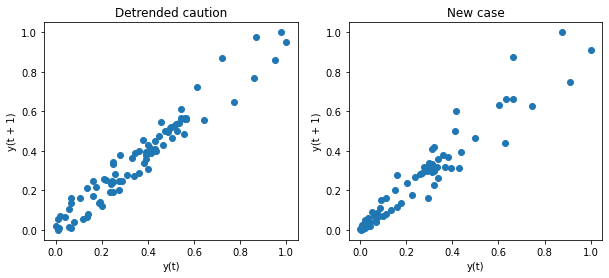

In [441]:
fig_lag, (ax1, ax2) = plt.subplots(1,2,figsize= (10,4))

pd.plotting.lag_plot(df_during.caution2,ax=ax1)
ax1.set_title('Detrended caution')
pd.plotting.lag_plot(df_during.new_case,ax=ax2)
ax2.set_title('New case')

Text(0.5, 1.0, 'Log(new cases)')

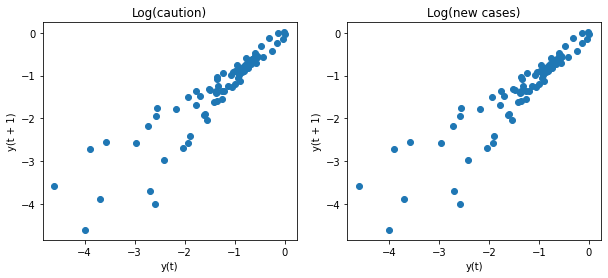

In [442]:
fig_lag_log, (ax1, ax2) = plt.subplots(1,2,figsize= (10,4))

pd.plotting.lag_plot(df_during.log_caution,ax=ax1)
ax1.set_title('Log(caution)')
pd.plotting.lag_plot(df_during.log_caution,ax=ax2)
ax2.set_title('Log(new cases)')

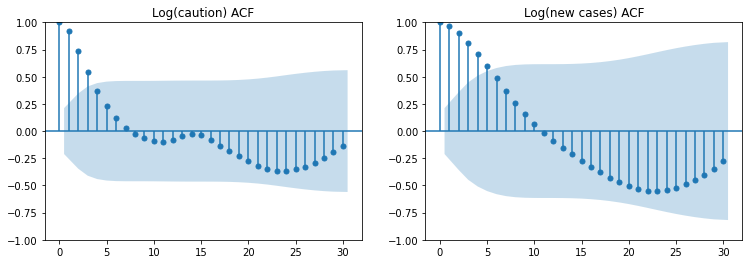

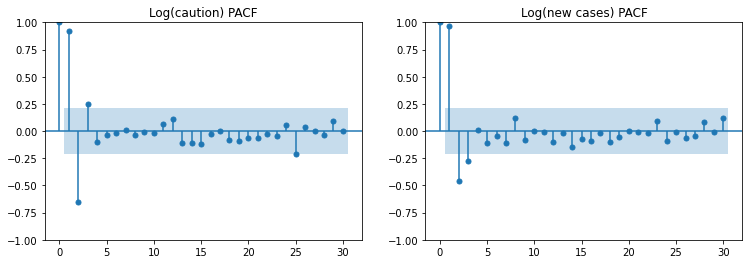

In [443]:
fig_acf, (ax1, ax2) = plt.subplots(1,2, figsize=(12.5,4))

plot_acf(df_during.log_caution, lags = 30, ax = ax1)
ax1.set_title('Log(caution) ACF')
plot_acf(df_during.log_new_case, lags = 30, ax = ax2)
ax2.set_title('Log(new cases) ACF')
plt.show()

fig_pacf, (ax1, ax2) = plt.subplots(1,2, figsize=(12.5,4))

plot_pacf(df_during.log_caution, lags = 30, ax = ax1, method='ywm')
ax1.set_title('Log(caution) PACF')
plot_pacf(df_during.log_new_case, lags = 30, ax = ax2, method='ywm')
ax2.set_title('Log(new cases) PACF')
plt.show()

In [491]:
df_sub = df_during[['new_case','caution2']]
train, test = df_sub[0:round(0.8*(len(df_sub.caution2)))], df_sub[round(0.8*(len(df_sub.caution2))):]

rank = select_coint_rank(train, det_order=0, k_ar_diff=3, method='maxeig', signif=0.05)

rank.summary()
# not quite


r_0,r_1,test statistic,critical value
0,1,12.52,14.26


C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


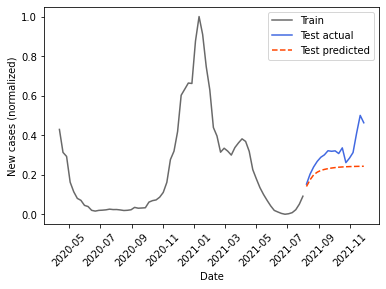

,coef,std err,z,P>|z|,[0.025,0.975]
L1.new_case,0.4262,0.114,3.722,0.000,0.202,0.651
L1.caution2,0.3323,0.180,1.848,0.065,-0.020,0.685
L2.new_case,0.0805,0.124,0.651,0.515,-0.162,0.323
L2.caution2,0.2967,0.261,1.135,0.256,-0.216,0.809
L3.new_case,0.0265,0.113,0.236,0.814,-0.194,0.247
L3.caution2,-0.4440,0.187,-2.371,0.018,-0.811,-0.077
,coef,std err,z,P>|z|,[0.025,0.975]
L1.new_case,0.0098,0.069,0.142,0.887,-0.126,0.145
L1.caution2,1.0190,0.109,9.383,0.000,0.806,1.232
L2.new_case,0.1086,0.075,1.454,0.146,-0.038,0.255


In [477]:
model_VECM = VECM(train, coint_rank=1, k_ar_diff=3)
vecm_res = model_VECM.fit()

fc_vecm, lower, upper = vecm_res.predict(steps=len(test), alpha=0.05)

plt.plot(train.new_case, color='dimgray')
plt.plot(test.new_case, color='royalblue')
plt.plot(test.index,fc_vecm[:,0], color='orangered',linestyle='--')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('New cases (normalized)')
plt.legend(['Train','Test actual','Test predicted'])
plt.show()

vecm_res.summary()

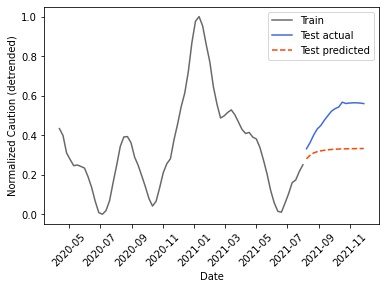

In [478]:
fig,ax = plt.subplots()

ax.plot(train.caution2,color='dimgray')
ax.plot(test.caution2,color='royalblue')
ax.plot(test.index,fc_vecm[:,1],color='orangered',linestyle='--')

ax.set_ylabel('Normalized Caution (detrended)')
ax.set_xlabel('Date')
ax.legend(['Train','Test actual','Test predicted'])

plt.xticks(rotation=45)
plt.show()

In [479]:
L=6
i=0
fc_ind = [None]*(L+1)
fc_ind[0]=df_sub.index[-1]
while i<L:
    fc_ind[i+1] = fc_ind[i] + pd.Timedelta(days=7)
    i+=1
    
#fc_ind=fc_ind[1:]
fc_ind

[Timestamp('2021-11-28 00:00:00'),
 Timestamp('2021-12-05 00:00:00'),
 Timestamp('2021-12-12 00:00:00'),
 Timestamp('2021-12-19 00:00:00'),
 Timestamp('2021-12-26 00:00:00'),
 Timestamp('2022-01-02 00:00:00'),
 Timestamp('2022-01-09 00:00:00')]

C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


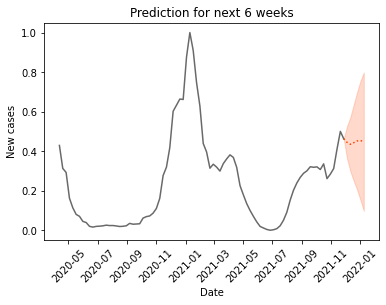

In [407]:
model_VECM = VECM(df_sub, coint_rank=1, k_ar_diff=3, dates=df_sub.index)
vecm_res = model_VECM.fit()

fc_vecm, lower, upper = vecm_res.predict(steps=L, alpha=0.05)

plt.plot(df_sub.new_case,color='dimgray')
plt.plot(fc_ind,np.insert(fc_vecm[:,0],0,df_sub.new_case.values[-1]),color='orangered',linestyle=':')

plt.fill_between(fc_ind,
                 np.insert(lower[:,0],0,df_sub.new_case.values[-1]),
                 np.insert(upper[:,0],0,df_sub.new_case.values[-1]),
                 color='orangered',alpha=0.2)

plt.ylabel('New cases')
plt.xlabel('Date')
plt.title('Prediction for next 6 weeks')

plt.xticks(rotation=45)
plt.show()


In [492]:
err_nc = [None]*(3)
err_nc_naive = [None]*3
err_cau = [None]*(3)
err_cau_naive = [None]*3
fc_weeks = 6
new_case_naive = [None]*fc_weeks
i = 0

for frac_train in np.arange(0.8,0.95, 0.05):
    train, test = df_sub[0:round(frac_train*(len(df_sub.caution2)))], df_sub[round(frac_train*(len(df_sub.caution2))):]
    
    model_VECM = VECM(train, coint_rank=1, k_ar_diff=3)
    vecm_res = model_VECM.fit()

    fc_vecm = vecm_res.predict(steps=fc_weeks)
    
    err_nc[i] = mape(test.new_case.values[:fc_weeks], fc_vecm[:,0])
    new_case_naive[0:fc_weeks] = np.repeat(test.new_case.values[0],fc_weeks)
    err_nc_naive[i] = mape(test.new_case.values[:fc_weeks],new_case_naive)
    
    err_cau[i] = mape(test.caution2.values[:fc_weeks], fc_vecm[:,1])
    new_case_naive[0:fc_weeks] = np.repeat(test.caution2.values[0],fc_weeks)
    err_cau_naive[i] = mape(test.caution2.values[:fc_weeks],new_case_naive)
    
    i+=1
    
print('Mean VECM new case',str(fc_weeks),'week MAPE error:', np.mean(err_nc))
print('Mean Naive new case',str(fc_weeks),'week MAPE error:', np.mean(err_nc_naive))

print('Mean VECM caution',str(fc_weeks),'week MAPE error:', np.mean(err_cau))
print('Mean Naive caution',str(fc_weeks),'week MAPE error:', np.mean(err_cau_naive))


Mean VECM new case 6 week MAPE error: 12.29737642456734
Mean Naive new case 6 week MAPE error: 16.000932197597596
Mean VECM caution 6 week MAPE error: 11.370288656098559
Mean Naive caution 6 week MAPE error: 10.58961043031984


C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


In [450]:
test.caution2

2021-10-03    0.534320
2021-10-10    0.542182
2021-10-17    0.566967
2021-10-24    0.560178
2021-10-31    0.562589
2021-11-07    0.563754
2021-11-14    0.563675
2021-11-21    0.562353
2021-11-28    0.559790
Name: caution2, dtype: float64

C:\Users\Ping\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=23.712, Time=0.12 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=79.821, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=27.855, Time=0.09 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=23.493, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=164.911, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=20.912, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=25.025, Time=0.05 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=33.609, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=158.929, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=68.805, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=31.288, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=131.258, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=23.949, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=155.087, Time=0.09 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=23.841, Time=0.15 sec
 ARIMA(4,0,1)(0,0,0)[0]             

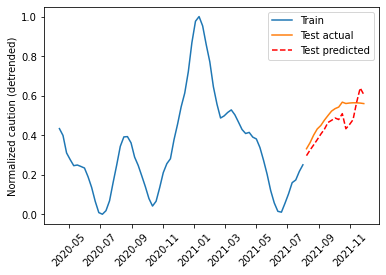

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   69
Model:               SARIMAX(2, 0, 3)   Log Likelihood                  -9.869
Date:                Wed, 08 Dec 2021   AIC                             33.737
Time:                        23:21:35   BIC                             49.376
Sample:                             0   HQIC                            39.942
                                 - 69                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6432      0.027     23.629      0.000       0.590       0.697
ar.L1          1.4962      0.141     10.615      0.000       1.220       1.772
ar.L2         -0.6650      0.139     -4.779      0.000      -0.938      -0.392
ma.L1         -0.1440      0.199     -0.723      0.469      -0.534       0.246
ma.L2         -0.4588      0.179     -2.557      0.011      -0.811      -0.107
ma.L3         -0.1894      0.200     -0.948      0.343      -0.581       0.202
sigma2         0.0752      0.012      6.530      0.000       0.053       0.098
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                54.10
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.87
Prob(H) (two-sided):                  0.27   Kurtosis:                         6.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [480]:
df_log = df_during[['log_new_case','log_caution']]
train, test = df_log[0:round(0.8*(len(df_during.log_caution)))], df_log[round(0.8*(len(df_during.log_caution))):]

model = auto_arima(df_during.log_caution,start_p=2, d=0, q=0, seasonal=False, trace=1, 
                   exogenous=np.reshape(df_during.log_new_case.values,(-1,1)),
                   stepwise=False, random=True, n_fits=50, random_state=1, method='nm')

model.fit(train.log_caution, exogenous=np.reshape(train.log_new_case.values,(-1,1)))
forecast = model.predict(exogenous=np.reshape(test.log_new_case.values,(-1,1)), n_periods=len(test))

forecast = pd.DataFrame(forecast,index = test.index,columns=['log_caution_pred'])
forecast = pd.concat([test,forecast],axis=1)
plt.plot(np.exp(train.log_caution)-epsilon)
plt.plot(np.exp(forecast.log_caution)-epsilon)
plt.plot(np.exp(forecast.log_caution_pred)-epsilon, color='red',linestyle='--')
plt.xticks(rotation=45)
plt.ylabel('Normalized caution (detrended)')
plt.legend(['Train','Test actual','Test predicted'])
plt.show()

model.summary()


In [493]:
err = [None]*(3)
err_naive = [None]*3
fc_weeks = 6
new_case_naive = [None]*fc_weeks
i = 0

for frac_train in np.arange(0.8,0.95, 0.05):    
    df_log = df_during[['log_new_case','log_caution']]
    train, test = df_log[0:round(frac_train*(len(df_during.log_caution)))], df_log[round(frac_train*(len(df_during.log_caution))):]

    model = auto_arima(df_during.log_caution,start_p=2, d=0, q=0, seasonal=False, trace=1, 
                   exogenous=np.reshape(df_during.log_new_case.values,(-1,1)),
                   stepwise=False, random=True, n_fits=50, random_state=1, method='nm')
    res = model.fit(train.log_caution, exogenous=np.reshape(train.log_new_case.values,(-1,1)))

    fc = model.predict(exogenous=np.reshape(test.log_new_case.values[:fc_weeks],(-1,1)), n_periods=fc_weeks)
    
    err[i] = mape(np.exp(test.log_caution.values[:fc_weeks])-epsilon, np.exp(fc)-epsilon)
    new_case_naive[0:fc_weeks] = np.repeat(test.log_caution.values[0],fc_weeks)
    err_naive[i] = mape(np.exp(test.log_caution.values[:fc_weeks])-epsilon, np.exp(new_case_naive)-epsilon)
    i+=1
    
print('Mean ARMAX',str(fc_weeks),'week error:', np.mean(err))
print('Mean Naive',str(fc_weeks),'week error:', np.mean(err_naive))

C:\Users\Ping\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=23.712, Time=0.12 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=79.821, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=27.855, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=23.493, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=164.911, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=20.912, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=25.025, Time=0.05 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=33.609, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=158.929, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=68.805, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=31.288, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=131.258, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=23.949, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=155.087, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=23.841, Time=0.07 sec
 ARIMA(4,0,1)(0,0,0)[0]             

C:\Users\Ping\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=23.712, Time=0.11 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=79.821, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=27.855, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=23.493, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=164.911, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=20.912, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=25.025, Time=0.06 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=33.609, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=158.929, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=68.805, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=31.288, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=131.258, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=23.949, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=155.087, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=23.841, Time=0.06 sec
 ARIMA(4,0,1)(0,0,0)[0]             

C:\Users\Ping\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=23.712, Time=0.16 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=79.821, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=27.855, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=23.493, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=164.911, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=20.912, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=25.025, Time=0.08 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=33.609, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=158.929, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=68.805, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=31.288, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=131.258, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=23.949, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=155.087, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=23.841, Time=0.09 sec
 ARIMA(4,0,1)(0,0,0)[0]             

In [490]:
(np.exp(test.log_caution.values[:fc_weeks])-epsilon)*range_cau+min_cau

array([0.04090715, 0.04326976, 0.05071823, 0.04867805, 0.04940255,
       0.04975264])

In [489]:
len(test)

9

C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


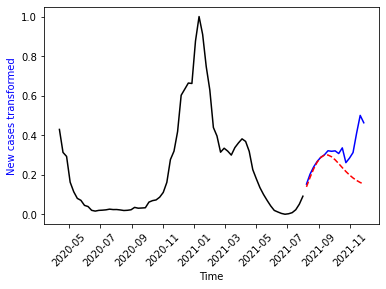

Dep. Variable:,"['log_new_case', 'log_caution']",No. Observations:,69
Model:,VAR(2),Log Likelihood,15.307
,+ intercept,AIC,-4.615
Date:,"Tue, 07 Dec 2021",BIC,24.429
Time:,13:29:33,HQIC,6.908
Sample:,04-12-2020,,
,- 08-01-2021,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"2.49, 1.59",Jarque-Bera (JB):,"0.40, 76.20"
Prob(Q):,"0.11, 0.21",Prob(JB):,"0.82, 0.00"
Heteroskedasticity (H):,"0.39, 0.78",Skew:,"-0.18, -0.10"


In [130]:
df_during2 = df_during.dropna()     # creating this helps indices stay in sync
#df_sta = df_during2[['new_case_sta','caution_sta']]
df_log = df_during2[['log_new_case','log_caution']]
train, test = df_log[0:round(0.8*(len(df_log.log_caution)))], df_during[round(0.8*(len(df_log.log_caution))):]
temp_train, temp_test = df_during2.temp_C[0:round(0.8*(len(df_log.log_caution)))], df_during2.temp_C[round(0.8*(len(df_log.log_caution))):]

#model2 = sm.tsa.VARMAX(endog=train, exog=temp_train, order=(2,0), trend='c')
# Temperature coefficient wasn't significant for FL, seemed to overweight winter surge of 2020 for NY
model2 = sm.tsa.VARMAX(endog=train, order = (2,0), trend='c')
model2_fit = model2.fit(maxiter=5000, disp=True)

# Only can forecast from end of sample
fc = model2_fit.forecast(steps=len(test.log_new_case))

fig,ax = plt.subplots()

ax.plot(np.exp(train.log_new_case)-epsilon,color='black')

ax.plot(np.exp(test.log_new_case)-epsilon,color='blue')
ax.set_ylabel('New cases transformed',color='blue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax.plot(np.exp(fc.log_new_case)-epsilon,color='red',linestyle='--')
plt.show()

model2_fit.summary()

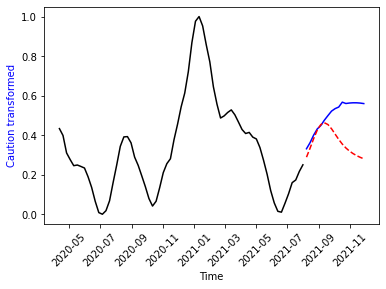

In [131]:
fig,ax = plt.subplots()

ax.plot(np.exp(train.log_caution)-epsilon,color='black')

ax.plot(np.exp(test.log_caution)-epsilon,color='blue')
ax.set_ylabel('Caution transformed',color='blue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax.plot(np.exp(fc.log_caution)-epsilon,color='red',linestyle='--')
plt.show()

In [171]:
df_during2 = df_during.dropna()     # creating this helps indices stay in sync
df_log = df_during2[['log_new_case','log_caution']]
train, test = df_log[0:round(0.8*(len(df_log.log_caution)))], df_during[round(0.8*(len(df_log.log_caution))):]
temp_train, temp_test = df_during2.temp_C[0:round(0.8*(len(df_log.log_caution)))], df_during2.temp_C[round(0.8*(len(df_log.log_caution))):]

#model2 = sm.tsa.VARMAX(endog=train, exog=temp_train, order=(2,0), trend='c')
# Temperature coefficient wasn't significant for FL, seemed to overweight winter surge of 2020 for NY
model2 = VAR(endog=train)
res = model2.select_order(9)
res.summary()


C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,-0.1477,-0.07723,0.8627,-0.1202
1,-4.309,-4.097,0.01345,-4.226
2,-5.939,-5.586*,0.002638,-5.801*
3,-5.968*,-5.475,0.002565*,-5.776
4,-5.936,-5.303,0.002654,-5.689
5,-5.824,-5.050,0.002981,-5.522
6,-5.718,-4.802,0.003335,-5.360
7,-5.642,-4.586,0.003626,-5.230
8,-5.654,-4.457,0.003623,-5.187
9,-5.535,-4.197,0.004137,-5.013


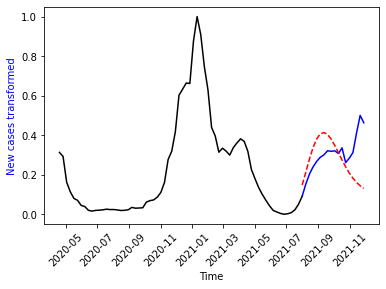

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 07, Dec, 2021
Time:                     16:42:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.34926
Nobs:                     64.0000    HQIC:                  -5.71725
Log likelihood:           26.9822    FPE:                 0.00259882
AIC:                     -5.95645    Det(Omega_mle):      0.00199752
--------------------------------------------------------------------
Results for equation log_new_case
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.076563         0.048535           -1.577           0.115
L1.log_new_case         1.524413         0.137781           11.064           0.000
L1.log_caution          0.158317         0.09

In [178]:
model2_fit = model2.fit(maxlags=4)

# Does not converge for 5, works horribly for other values

# Only can forecast from end of sample 
lag_order = model2_fit.k_ar 
forecast_input = train.values[-lag_order:]
fc = model2_fit.forecast(forecast_input, steps=len(test))

fig,ax = plt.subplots()

ax.plot(np.exp(train.log_new_case)-epsilon,color='black')

ax.plot(np.exp(test.log_new_case)-epsilon,color='blue')
ax.set_ylabel('New cases transformed',color='blue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax.plot(test.index,np.exp(fc[:,0])-epsilon,color='red',linestyle='--')
plt.show()

model2_fit.summary()

C:\Users\Ping\AppData\Local\Temp/ipykernel_29788/3211017030.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['new_case_sta'] = df_during.new_case.diff()


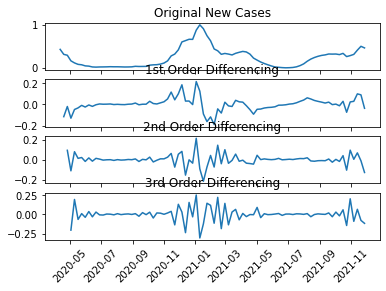

In [280]:
# Make stationary with differencing

fig, axes = plt.subplots(4, 1, sharex=True)
axes[0].plot(df_during.new_case); axes[0].set_title('Original New Cases')

# 1st Differencing
axes[1].plot(df_during.new_case.diff()); axes[1].set_title('1st Order Differencing')

# 2nd Differencing
axes[2].plot(df_during.new_case.diff().diff()); axes[2].set_title('2nd Order Differencing')

# 3rd Differencing
axes[3].plot(df_during.new_case.diff().diff().diff()); axes[3].set_title('3rd Order Differencing')
plt.xticks(rotation=45)

# Autocorrelogram on new cases
#plot_acf(df.value, ax=axes[0, 1])
#plot_acf(df.value.diff().dropna(), ax=axes[1, 1])
#plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

result = adfuller(df_during.new_case.diff().dropna())
result
# result[0] is test statistic, result[1] is p-val
# p-val < 0.05, so time series is stationary enough after one round of differencing, value gets smaller with more rounds
# visually looks reasonable after 2 rounds, no better with 3 rounds

df_during['new_case_sta'] = df_during.new_case.diff()

C:\Users\Ping\AppData\Local\Temp/ipykernel_29788/2792412098.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['caution_sta'] = df_during.caution.diff()


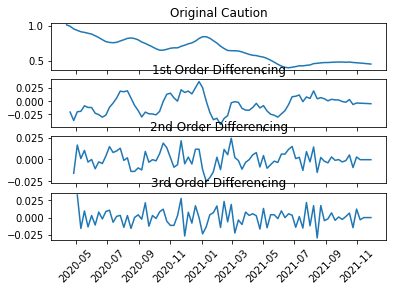

In [140]:
fig, axes = plt.subplots(4, 1, sharex=True)
axes[0].plot(df_during.caution); axes[0].set_title('Original Caution')

# 1st Differencing
axes[1].plot(df_during.caution.diff()); axes[1].set_title('1st Order Differencing')

# 2nd Differencing
axes[2].plot(df_during.caution.diff().diff()); axes[2].set_title('2nd Order Differencing')

# 3rd Differencing
axes[3].plot(df_during.caution.diff().diff().diff()); axes[3].set_title('3rd Order Differencing')
plt.xticks(rotation=45)

result = adfuller(df_during.caution.diff().dropna())
result

df_during['caution_sta'] = df_during.caution.diff()
df_during2 = df_during.dropna()

In [142]:
grangercausalitytests(df_during2[['caution_sta','new_case_sta']],maxlag=12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1221  , p=0.7277  , df_denom=81, df_num=1
ssr based chi2 test:   chi2=0.1266  , p=0.7220  , df=1
likelihood ratio test: chi2=0.1265  , p=0.7221  , df=1
parameter F test:         F=0.1221  , p=0.7277  , df_denom=81, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5527  , p=0.5777  , df_denom=78, df_num=2
ssr based chi2 test:   chi2=1.1762  , p=0.5554  , df=2
likelihood ratio test: chi2=1.1679  , p=0.5577  , df=2
parameter F test:         F=0.5527  , p=0.5777  , df_denom=78, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1558  , p=0.0296  , df_denom=75, df_num=3
ssr based chi2 test:   chi2=10.3510 , p=0.0158  , df=3
likelihood ratio test: chi2=9.7479  , p=0.0208  , df=3
parameter F test:         F=3.1558  , p=0.0296  , df_denom=75, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7880  , p=0.1406  , df_d

{1: ({'ssr_ftest': (0.12207036316586677, 0.7277064739121305, 81.0, 1),
   'ssr_chi2test': (0.12659148772756554, 0.7219926143224686, 1),
   'lrtest': (0.12649619414241897, 0.7220929313345865, 1),
   'params_ftest': (0.12207036316588732, 0.727706473912092, 81.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.5526594773941762, 0.577653956589048, 78.0, 2),
   'ssr_chi2test': (1.1761727339414518, 0.5553890793542064, 2),
   'lrtest': (1.1679170074716012, 0.5576863877413327, 2),
   'params_ftest': (0.5526594773941735, 0.5776539565890505, 78.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (3.155779123999169, 0.029634780153913718, 75.0, 3),
   'ssr_chi2test': (10.350955526717273, 0.015806797911764283, 3),
   'lrtest': (9.747898102219096, 0.020835253720149466, 3),
   'params_ftest': (3.155779123999178, 0.029634780153913503, 75.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.,

In [144]:
grangercausalitytests(df_during2[['new_case_sta','caution_sta']],maxlag=12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.6385 , p=0.0003  , df_denom=81, df_num=1
ssr based chi2 test:   chi2=15.1807 , p=0.0001  , df=1
likelihood ratio test: chi2=13.9546 , p=0.0002  , df=1
parameter F test:         F=14.6385 , p=0.0003  , df_denom=81, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.2379  , p=0.0013  , df_denom=78, df_num=2
ssr based chi2 test:   chi2=15.4038 , p=0.0005  , df=2
likelihood ratio test: chi2=14.1298 , p=0.0009  , df=2
parameter F test:         F=7.2379  , p=0.0013  , df_denom=78, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.3392  , p=0.0007  , df_denom=75, df_num=3
ssr based chi2 test:   chi2=20.7925 , p=0.0001  , df=3
likelihood ratio test: chi2=18.5314 , p=0.0003  , df=3
parameter F test:         F=6.3392  , p=0.0007  , df_denom=75, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.2521  , p=0.0009  , df_d

{1: ({'ssr_ftest': (14.63849066987922, 0.00025505950884944844, 81.0, 1),
   'ssr_chi2test': (15.180656990985858, 9.769908858852917e-05, 1),
   'lrtest': (13.954601339638373, 0.00018727870304518197, 1),
   'params_ftest': (14.638490669879195, 0.0002550595088494528, 81.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (7.237921927029404, 0.0013079335737837244, 78.0, 2),
   'ssr_chi2test': (15.40378256265232, 0.0004519715686504797, 2),
   'lrtest': (14.129806804612144, 0.0008545774665873749, 2),
   'params_ftest': (7.237921927029371, 0.0013079335737837647, 78.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (6.339166030130254, 0.0006870379173785173, 75.0, 3),
   'ssr_chi2test': (20.792464578827232, 0.0001162574586249635, 3),
   'lrtest': (18.53140970723348, 0.0003416876178827801, 3),
   'params_ftest': (6.339166030130254, 0.0006870379173785173, 75.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.]

In [351]:
model = auto_arima(df_during.caution, start_p=3, d=1, start_q=1, exogenous=np.reshape(df_during.new_case.values,(-1,1)),
                   trace=1, seasonal= False, stepwise=False, random=True, n_fits=30, random_state=0) 
model.fit(train.caution, exogenous=np.reshape(train.new_case.values,(-1,1)))
forecast = model.predict(exogenous=np.reshape(test.new_case.values,(-1,1)), n_periods=len(test))

model.summary()

C:\Users\Ping\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-573.026, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-570.731, Time=0.34 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-562.052, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-517.527, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-554.639, Time=0.33 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-568.851, Time=0.39 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-568.828, Time=0.37 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-563.523, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-549.762, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-560.758, Time=0.82 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-571.032, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-561.139, Time=0.20 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-568.808, Time=0.42 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-562.896, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-570.740, Time=0.37 sec
 ARIMA(1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   69
Model:               SARIMAX(1, 1, 2)   Log Likelihood                 231.892
Date:                Mon, 06 Dec 2021   AIC                           -451.785
Time:                        22:47:37   BIC                           -438.468
Sample:                             0   HQIC                          -446.508
                                 - 69                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0035      0.003     -1.276      0.202      -0.009       0.002
x1            -0.0040      0.012     -0.329      0.742      -0.028       0.020
ar.L1          0.5849      0.127      4.591      0.000       0.335       0.835
ma.L1          0.5623      0.097      5.813      0.000       0.373       0.752
ma.L2          0.7453      0.092      8.143      0.000       0.566       0.925
sigma2      6.075e-05   9.77e-06      6.216      0.000    4.16e-05    7.99e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 3.78
Prob(Q):                              0.68   Prob(JB):                         0.15
Heteroskedasticity (H):               0.74   Skew:                             0.47
Prob(H) (two-sided):                  0.47   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
fc

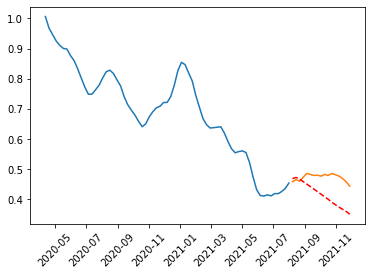

12.662980877919411

In [340]:
forecast = pd.DataFrame(forecast,index = test.index,columns=['caution_pred'])
forecast = pd.concat([test,forecast],axis=1)
plt.plot(train.caution)
plt.plot(forecast.caution)
plt.plot(forecast.caution_pred, color='red',linestyle='--')
plt.xticks(rotation=45)
plt.show()

mape(forecast.caution, forecast.caution_pred)

In [341]:
model = auto_arima(df_during.new_case, start_p=2, d=2, start_q=2, exogenous=np.reshape(df_during.caution.values,(-1,1)),
                   trace=1, seasonal= False, stepwise=False, random=True, n_fits=30, random_state=0) 
model.fit(train.new_case, exogenous=np.reshape(train.caution.values,(-1,1)))
forecast = model.predict(exogenous=np.reshape(test.caution.values,(-1,1)), n_periods=len(test))

C:\Users\Ping\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-246.951, Time=0.38 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-247.498, Time=0.29 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-240.704, Time=0.33 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-242.502, Time=0.17 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-237.666, Time=0.19 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=-247.002, Time=0.42 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-242.657, Time=0.30 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-238.362, Time=0.09 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-240.901, Time=0.35 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=-251.363, Time=0.30 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-247.887, Time=0.26 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=-250.312, Time=0.39 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-243.264, Time=0.32 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-249.395, Time=0.39 sec
 ARIMA(1,2,1)(0

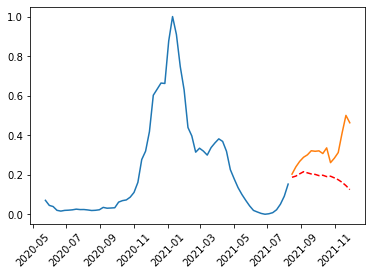

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   64
Model:               SARIMAX(0, 2, 3)   Log Likelihood                  95.605
Date:                Mon, 06 Dec 2021   AIC                           -179.209
Time:                        21:36:07   BIC                           -166.446
Sample:                             0   HQIC                          -174.198
                                 - 64                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0003      0.001     -0.360      0.719      -0.002       0.001
x1             0.9893      0.620      1.596      0.111      -0.226       2.205
ma.L1         -0.4258      0.117     -3.643      0.000      -0.655      -0.197
ma.L2         -0.2523      0.104     -2.415      0.016      -0.457      -0.048
ma.L3         -0.2513      0.116     -2.166      0.030      -0.479      -0.024
sigma2         0.0026      0.000      8.449      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                41.80
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               3.79   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [276]:
forecast = pd.DataFrame(forecast,index = test.index,columns=['new_case_pred'])
forecast = pd.concat([test,forecast],axis=1)
plt.plot(train.new_case)
plt.plot(forecast.new_case)
plt.plot(forecast.new_case_pred, color='red',linestyle='--')
plt.xticks(rotation=45)
plt.show()

model.summary()

In [357]:
df_during2 = df_during.dropna()     # creating this helps indices stay in sync
#df_sta = df_during2[['new_case_sta','caution_sta']]
df_log = df_during2[['log_new_case','log_caution']]
#train, test = df_sta[0:round(0.8*(len(df_sta.caution_sta)))], df_sta[round(0.8*(len(df_sta.caution_sta))):]
train, test = df_log[0:round(0.8*(len(df_log.log_caution)))], df_during[round(0.8*(len(df_log.log_caution))):]
print(train.shape, test.shape)

for i in range(1,9):
    model = VAR(endog=train)
    model_fit = model.fit(i)
    print('maxlag :',i)
    print('AIC : ', model_fit.aic)

model_fit = model.fit(maxlags=12, ic='aic',verbose='true')
    
lag_order = model_fit.k_ar 

#model_fit = model.fit(lag_order)
model_fit = model.fit(lag_order)
model_fit.summary()



(68, 2) (18, 8)
maxlag : 1
AIC :  -4.350004374188915
maxlag : 2
AIC :  -5.88615095913036
maxlag : 3
AIC :  -6.0192096728357765
maxlag : 4
AIC :  -5.9564484666065916
maxlag : 5
AIC :  -5.855633376151274
maxlag : 6
AIC :  -5.712508464967333
maxlag : 7
AIC :  -5.629009064708203
maxlag : 8
AIC :  -5.599487834363648
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 2, BIC -> 2, FPE -> 2, HQIC ->  2>
Using 2 based on aic criterion


C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency 

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 06, Dec, 2021
Time:                     22:54:10
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.55439
Nobs:                     66.0000    HQIC:                  -5.75505
Log likelihood:           16.9431    FPE:                 0.00277926
AIC:                     -5.88615    Det(Omega_mle):      0.00240160
--------------------------------------------------------------------
Results for equation log_new_case
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.087348         0.046122           -1.894           0.058
L1.log_new_case         1.642611         0.090229           18.205           0.000
L1.log_caution          0.143714         0.05

C:\Users\Ping\AppData\Local\Temp/ipykernel_9584/1401064205.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['log_new_case_fc']=df_fc_test['log_new_case_fc']
C:\Users\Ping\AppData\Local\Temp/ipykernel_9584/1401064205.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['log_caution_fc']=df_fc_test['log_caution_fc']


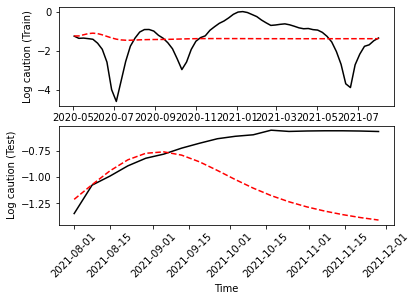

In [364]:
start = 0
forecast_input = train.values[start:start+lag_order]
fc_train = model_fit.forecast(forecast_input, steps=len(train)-start-lag_order)
df_fc_train = pd.DataFrame(fc_train, index = df_log.index[start+lag_order:len(train)], columns = df_log.columns + '_fc')
df_fc_train['log_new_case'] = train.values[start+lag_order:,0]
df_fc_train['log_caution'] = train.values[start+lag_order:,1]

forecast_input2 = train.values[-lag_order:]
fc = model_fit.forecast(y=forecast_input2, steps=len(test))
df_fc_test = pd.DataFrame(fc, index=df_log.index[-len(test):], columns=df_log.columns + '_fc')

test['log_new_case_fc']=df_fc_test['log_new_case_fc']
test['log_caution_fc']=df_fc_test['log_caution_fc']

fig,ax = plt.subplots(2,1)

ax[0].plot(df_fc_train.log_caution,color='black')
ax[0].set_ylabel('Log caution (Train)',color='black')
ax[0].set_xlabel('Time')
ax[0].plot(df_fc_train.log_caution_fc,color='red',linestyle='--')

ax[1].plot(test.log_caution,color='black')
ax[1].set_ylabel('Log caution (Test)',color='black')
ax[1].set_xlabel('Time')
plt.xticks(rotation=45)
ax[1].plot(test.log_caution_fc,color='red',linestyle='--')
plt.show()

C:\Users\Ping\AppData\Local\Temp/ipykernel_9584/2442357608.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['new_case_fc']=df_fc['new_case_sta_fc']
C:\Users\Ping\AppData\Local\Temp/ipykernel_9584/2442357608.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['caution_fc']=df_fc['caution_sta_fc']


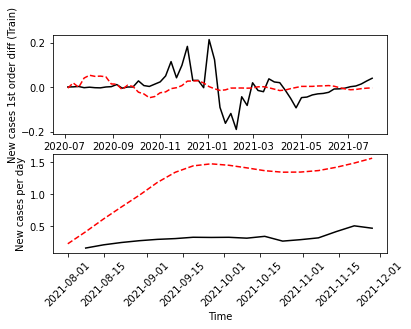

In [356]:
start = 0
forecast_input = train.values[start:start+lag_order]
fc_train = model_fit.forecast(forecast_input, steps=len(train)-start-lag_order)
df_fc_train = pd.DataFrame(fc_train, index = df_sta.index[start+lag_order:len(train)], columns = df_sta.columns + '_fc')
df_fc_train['new_case_sta'] = train.values[start+lag_order:,0]

forecast_input2 = train.values[-lag_order:]
fc = model_fit.forecast(y=forecast_input2, steps=len(test))
df_forecast = pd.DataFrame(fc, index=df_sta.index[-len(test):], columns=df_sta.columns + '_2d')

df_fc = df_forecast.copy()
columns = df_sta.columns
df_check = pd.DataFrame()

for col in columns: 
    col_orig = col.replace("_sta","")
    # De-difference 2nd
    df_fc[str(col)+'_1d'] = (df_during2[col_orig].iloc[len(train)-1]-df_during2[col_orig].iloc[len(train)-2]) + df_fc[str(col)+'_2d'].cumsum()
    
    # De-difference again
    df_fc[str(col)+'_fc'] = df_during2[col_orig].iloc[len(train)-1] + df_fc[str(col)+'_1d'].cumsum()

# Check
    df_check['new_case_1d'] = (df_during2['new_case'].iloc[len(train)-1]-df_during2['new_case'].iloc[len(train)-2]) + test["new_case_sta"].cumsum()
   
    df_check['new_case'] = df_during2['new_case'].iloc[len(train)-1] + df_check["new_case_1d"].cumsum()


test['new_case_fc']=df_fc['new_case_sta_fc']
test['caution_fc']=df_fc['caution_sta_fc']

fig,ax = plt.subplots(2,1)

ax[0].plot(df_fc_train.new_case_sta,color='black')
ax[0].set_ylabel('New cases 1st order diff (Train)',color='black')
ax[0].set_xlabel('Time')
ax[0].plot(df_fc_train.new_case_sta_fc,color='red',linestyle='--')

ax[1].plot(df_during2.new_case[round(0.8*(len(df_sta.caution_sta))):],color='black')
ax[1].set_ylabel('New cases per day',color='black')
ax[1].set_xlabel('Time')
plt.xticks(rotation=45)

ax[1].plot(test.new_case_fc,color='red',linestyle='--')
plt.show()


In [926]:
mape(df_during2.new_case[round(0.9*(len(df_sta.caution_sta))):], test.new_case_fc)

57.907524306296054

In [283]:
df_during_sub = df_during[['new_case','caution']].dropna()
train, test = df_during_sub[0:round(0.85*(len(df_during_sub.caution)))], df_during_sub[round(0.85*(len(df_during_sub.caution))):]
print(train.shape, test.shape)

model = VAR(endog=train)
model_fit = model.fit(maxlags=8, ic='aic',verbose='true',trend='ct')

lag_order = model_fit.k_ar  
#lag order 5 was selected
model_fit.summary()

(68, 2) (12, 2)
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 4, BIC -> 3, FPE -> 4, HQIC ->  4>
Using 4 based on aic criterion


C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 06, Dec, 2021
Time:                     21:37:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.4728
Nobs:                     64.0000    HQIC:                  -14.8817
Log likelihood:           323.095    FPE:                2.65323e-07
AIC:                     -15.1475    Det(Omega_mle):     1.98459e-07
--------------------------------------------------------------------
Results for equation new_case
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.100265         0.240776           -0.416           0.677
trend               0.000875         0.001985            0.441           0.659
L1.new_case         1.430134         0.136016           10.514   

C:\Users\Ping\AppData\Local\Temp/ipykernel_9584/1145738384.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['new_case_fc']=fc[:,0]
C:\Users\Ping\AppData\Local\Temp/ipykernel_9584/1145738384.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['caution_fc']=fc[:,1]


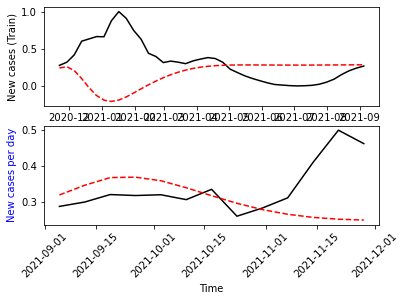

In [257]:
start = 25
forecast_input = train.values[start:start+lag_order]
fc_train = model_fit.forecast(forecast_input, steps=len(train)-start-lag_order)
df_fc_train = pd.DataFrame(fc_train, index = df_sta.index[start+lag_order:len(train)], columns = df_sta.columns + '_fc')
df_fc_train['new_case'] = train.values[start+lag_order:,0]

forecast_input2 = train.values[-lag_order:]
fc = model_fit.forecast(forecast_input2, steps=len(test.new_case))
test['new_case_fc']=fc[:,0]
test['caution_fc']=fc[:,1]

fig,ax = plt.subplots(2,1)

ax[0].plot(df_fc_train.new_case,color='black')
ax[0].set_ylabel('New cases (Train)',color='black')
ax[0].set_xlabel('Time')
ax[0].plot(df_fc_train.new_case_sta_fc,color='red',linestyle='--')

ax[1].plot(test.new_case,color='black')
ax[1].set_ylabel('New cases per day',color='blue')
ax[1].set_xlabel('Time')
plt.xticks(rotation=45)

ax[1].plot(test.new_case_fc,color='red',linestyle='--')
plt.show()


In [929]:
mape(test.new_case, test.new_case_fc)


45.67397032473607

C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


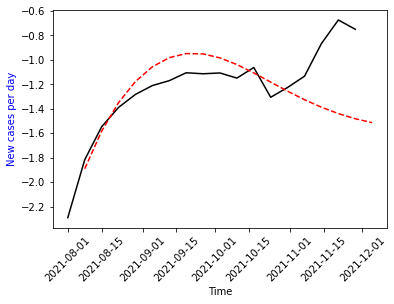

Dep. Variable:,"['log_new_case', 'log_caution']",No. Observations:,68
Model:,VAR(2),Log Likelihood,15.412
,+ intercept,AIC,-0.824
Date:,"Mon, 06 Dec 2021",BIC,32.469
Time:,23:09:56,HQIC,12.368
Sample:,04-19-2020,,
,- 08-01-2021,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"1.37, 1.54",Jarque-Bera (JB):,"0.32, 59.96"
Prob(Q):,"0.24, 0.21",Prob(JB):,"0.85, 0.00"
Heteroskedasticity (H):,"0.42, 0.77",Skew:,"-0.15, -0.09"


In [ ]:
plt_acf(dataset[i], lags = 50)
  plt.title('ACF for %s' % i)